#### CIE4604 Simulation and Visualization

# Module 3 2.5D Visualization - Exercise 4 (animate)

**Hans van der Marel, 29 November 2020** (updated 29 November 2021)

In this exercise is shown how to make an animation (video) in Python. As an example we use NDVI computed from Sentinel-2 data for the period of one year starting April 2017.

## Import the modules

Matplotlib's animation module is imported for the animations, furthermore,  `rasterio` is used for reading GeoTIFF files together with a few other modules that we need. For details on `raterio` and it's installation see Exercise 3 of this module. If the `rasterio` module cannot be found, then it may be the case that you are not in the correct virtual environment.

In [1]:
# Importing all the libraries required for this exercise
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
import pandas as pd
import rasterio
from scipy.io import loadmat
from datetime import date, datetime


## Open NDVI dataset for an agricultural area near Sevilla (Spain)

Sentinel-2 NDVI data is provided for Sector BXII, an agricultural area located close to Sevilla (Spain). The two input files are

* `NDVI_BXII_time_series_2017_2018_S2A_SP.tif` (GeoTIFF with NDVI timeseries) 
* `NDVI_BXII_time_series_images_list.csv`  (Csv-file with the date, day number and day of year for the images)

The GeoTIFF file with NDVI is read using `rasterio` (See exercise 3). After first inspecting some of the dataset attributes, finally the following variables are created


* NDVI - 3-D array with dimensions [time, lat, lon] , i.e. NDVI[k,:,:] contains the k'th NDVI image at time ts[k] 
* ts, tsdoy, tsdatestring - 1-D arrays with respectively number of days since 12/04/2017 (ts), day of year (tsdoy) and datestrings (tsdatestring).

You should definitely take a look at each variable to see what it is about.

### Open the dataset object

First set the path to the folder with the files (you may have to adjust this) and variables with the filenames.

In [2]:
# set the filename and filepath

path = '../assignment3/cie4604_a3_hants/Hants/'
NDVIfile = 'NDVI_BXII_time_series_2017_2018_S2A_SP.tif'
Datefile = 'NDVI_BXII_time_series_images_list.csv'


In [3]:
# open GeoTIFF dataset as an object
src = rasterio.open(path + NDVIfile)

# print object
print('dataset object', src)


dataset object <open DatasetReader name='../assignment3/cie4604_a3_hants/Hants/NDVI_BXII_time_series_2017_2018_S2A_SP.tif' mode='r'>


Rasterio’s `open()` function takes a path string or path-like object and returns an opened dataset object. The path may point 
to a file of any supported raster format. Rasterio will open it using the proper GDAL format driver. Dataset objects have some of the same attributes as Python file objects.

In [4]:
print('Dataset name', src.name)
print('Read/write mode', src.mode)
print('Close status', src.closed)


Dataset name ../assignment3/cie4604_a3_hants/Hants/NDVI_BXII_time_series_2017_2018_S2A_SP.tif
Read/write mode r
Close status False


### Dataset properties

Properties of the raster data stored in the GeoTIFF can be accessed through attributes of the opened dataset object. Let's explore all of them and print.

In [5]:
# print out metadata information
print(src.meta)


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 866, 'height': 800, 'count': 33, 'crs': CRS.from_epsg(32630), 'transform': Affine(20.0, 0.0, 214920.0,
       0.0, -20.0, 4106200.0)}


In [6]:
for key in src.meta:
    print(key, ': ', src.meta[key])


driver :  GTiff
dtype :  float64
nodata :  None
width :  866
height :  800
count :  33
crs :  EPSG:32630
transform :  | 20.00, 0.00, 214920.00|
| 0.00,-20.00, 4106200.00|
| 0.00, 0.00, 1.00|


In [7]:
print('Number of bands', src.count)
print('Number of columns', src.width)
print('Number of rows', src.height)


Number of bands 33
Number of columns 866
Number of rows 800


Our dataset has 33 bands. Each band is NDVI at some date. The dates are not stored in the GeoTIFF, this is why there are two files. The second file contains infomation on the dates. 

A dataset band is an array of values representing the partial distribution of a single variable in 2-dimensional (2D) space. All band arrays of a dataset have the same number of rows and columns. The variable represented by the example dataset’s 33 bands are `float64` NDVI values. The array of data values is 866 columns wide and 800 rows high.

### Georeferencing information

The georeferencing information is given by the **transform** and **crs** properties. The transform property described an affine transformation. Derived from transformation is the **bounds** property, from which we compute the extent parameter for matplotlib's `imshow`
```
extent = [ src.bounds.left ,  src.bounds.right ,  src.bounds.bottom ,  src.bounds.top ]

```
The bounds and extent are

In [8]:
print(src.bounds)


BoundingBox(left=214920.0, bottom=4090200.0, right=232240.0, top=4106200.0)


In [9]:
extent = [src.bounds.left,  src.bounds.right,
          src.bounds.bottom,  src.bounds.top]
print(extent)


[214920.0, 232240.0, 4090200.0, 4106200.0]


The coordinate reference system (CRS) for the the coordinates is given by the **crs** attribute. 

In [10]:
print(type(src.crs))
print(src.crs)


<class 'rasterio.crs.CRS'>
EPSG:32630


Rasterio follows pyproj and uses PROJ.4 syntax in dict form as its native CRS syntax. 
The WKT representation of the CRS is given by the CRS class’s wkt attribute.
```
src.crs.wkt
```
Rasterio uses under the hood the `pyproj` module, which provides a interface to the `PROJ`  generic coordinate transformation software that transforms geospatial coordinates from one coordinate reference system (CRS) to another. This includes cartographic projections as well as geodetic transformations, see https://proj.org/ .

In [11]:
print(src.crs.wkt)


PROJCS["WGS_1984_UTM_Zone_30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


This UTM (Universal Transverse Mercator) zone 30N that is used for mapping areas in the Northern Hemisphere between 6 and 0 degrees West, with central meridian 3 degrees West.

### Read the NDVI data

The `read()` method returns for our dataset a Numpy 3-D array, with on the first axis (axis=0) are 33 bands, followed by 800 rows (axis=1)  and 866 columns (axis=2).

In [12]:
# Read the NDVI data
NDVI = src.read()
print('NDVI shape', NDVI.shape)


NDVI shape (33, 800, 866)


Data from a raster band can also be accessed by the band’s index number. Following the GDAL convention, bands are indexed from 1. The result is a 2-D array.

In [13]:
print('Indexes', src.indexes)
band1 = src.read(1)
print('Band-1 shape', band1.shape)


Indexes (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33)
Band-1 shape (800, 866)


### Spatial indexing

Datasets have an **index()** method for getting the array indices corresponding to points in georeferenced space. To get the value for the pixel 10 kilometers east and 5 kilometers south of the dataset’s upper left corner, do the following

In [14]:
x, y = (src.bounds.left + 10000, src.bounds.top - 5000)
row, col = src.index(x, y)
print('row, col', row, col)

value = band1[row, col]
print('value Band-1', value)

values = NDVI[:, row, col]
print('all NDVI values', values)


row, col 250 500
value Band-1 0.020994001999497414
all NDVI values [ 0.020994    0.06916484  0.16392364  0.09012295  0.65375608  0.80354708
  0.86006314  0.81399202  0.73016644  0.71495092  0.57604879  0.22982351
  0.06738197  0.08303434  0.08119434  0.06898486  0.06434024  0.04516502
  0.0104797   0.08500164  0.1662416   0.34310851 -0.01986077  0.65388304
  0.15663698  0.00357372  0.71235722  0.40543294  0.40448675  0.08188586
  0.05950761  0.08983957  0.08060619]


To get the spatial coordinates of a pixel, use the dataset’s **xy()** method. The coordinates of the center of the image can be computed like this

In [15]:
x, y = src.xy(src.height // 2, src.width // 2)
print('x, y', x, y)


x, y 223590.0 4098190.0


## Prepare date information

The date when the images were taken is provided in the csv file `NDVI_BXII_time_series_images_list.csv`. 
The date is not part of the GeoTIFF file, so this is provided in a separate csv file.

The csv file is read using `read_csv()` from `pandas`. The csv-file contains the band, the date, sequential day number starting with 1 for the first image, and the day of year. The first image was taken on 12 April 2017.

Three arrays with date information are provided

- the 1-D array *ts* with the day number (day 1 is the 12 April 2017)
- the 1-D array *tsdatestrings* with the formatted ISO date (yyyy-mm-dd)
- the 1-D array *tsdoy* with the day of the year


In [16]:
# Read dates using Panda
datetable = pd.read_csv(path + Datefile)

# Preview the first 5 lines of the loaded dates
datetable.head()

# Preview the data types
print(datetable.dtypes)

# Convert to 1-D numpy arrays
ts = np.array(datetable.Day)
tsdatestrings = np.array(datetable.ISOdate)
tsdoy = np.array(datetable.Doy)
print('ts', ts)
print('tsdatestrings', tsdatestrings)
print('tsdoy', tsdoy)


Band        int64
ISOdate    object
Day         int64
Doy         int64
dtype: object
ts [  1  11  21  31  41  51  61  71  81  91 101 111 131 141 151 161 171 181
 191 201 211 221 231 241 261 271 291 301 311 321 341 351 371]
tsdatestrings [' 2017-04-12' ' 2017-04-22' ' 2017-05-02' ' 2017-05-12' ' 2017-05-22'
 ' 2017-06-01' ' 2017-06-11' ' 2017-06-21' ' 2017-07-01' ' 2017-07-11'
 ' 2017-07-21' ' 2017-07-31' ' 2017-08-20' ' 2017-08-30' ' 2017-09-09'
 ' 2017-09-19' ' 2017-09-29' ' 2017-10-09' ' 2017-10-19' ' 2017-10-29'
 ' 2017-11-08' ' 2017-11-18' ' 2017-11-28' ' 2017-12-08' ' 2017-12-28'
 ' 2018-01-07' ' 2018-01-27' ' 2018-02-06' ' 2018-02-16' ' 2018-02-26'
 ' 2018-03-18' ' 2018-03-28' ' 2018-04-17']
tsdoy [102 112 122 132 142 152 162 172 182 192 202 212 232 242 252 262 272 282
 292 302 312 322 332 342 362   7  27  37  47  57  77  87 107]


There is also a mat file with the dates that can be used instead of the csv file (you may skip this part).

In [17]:
ts = loadmat(path + 'ts.mat')['ts']
ts = np.squeeze(ts)

tsdates = (date.toordinal(date(2017, 4, 12)) + 366) + ts - 1
tsdatestrings = []
for tsdate in tsdates:
    tsdatestrings.append(datetime.fromordinal(
        tsdate - 366).strftime('%Y-%m-%d'))

print('ts', ts)
print('tsdates', tsdates)
print('tsdatestrings', tsdatestrings)


ts [  1  11  21  31  41  51  61  71  81  91 101 111 131 141 151 161 171 181
 191 201 211 221 231 241 261 271 291 301 311 321 341 351 371]
tsdates [736797 736807 736817 736827 736837 736847 736857 736867 736877 736887
 736897 736907 736927 736937 736947 736957 736967 736977 736987 736997
 737007 737017 737027 737037 737057 737067 737087 737097 737107 737117
 737137 737147 737167]
tsdatestrings ['2017-04-12', '2017-04-22', '2017-05-02', '2017-05-12', '2017-05-22', '2017-06-01', '2017-06-11', '2017-06-21', '2017-07-01', '2017-07-11', '2017-07-21', '2017-07-31', '2017-08-20', '2017-08-30', '2017-09-09', '2017-09-19', '2017-09-29', '2017-10-09', '2017-10-19', '2017-10-29', '2017-11-08', '2017-11-18', '2017-11-28', '2017-12-08', '2017-12-28', '2018-01-07', '2018-01-27', '2018-02-06', '2018-02-16', '2018-02-26', '2018-03-18', '2018-03-28', '2018-04-17']


## Scaled image plot of NDVI for the first day

To plot the NDVI for the first day we are going to use matplotlib's `imshow` method to make a pseudo-color map. A good colormap for the NDVI is essential! It is up to you to come up with a good colormap for the NDVI, taking into account the lessons learned from Exercise 1 and 2. 

### Colormap selection

Start by formulating the requirements for the color map. What kind of color map should we select? What is the range? Do we use a linear map, is it continuous or discrete, do we use two tones?  What kind of normalization are we going to use?
In any case, the default color map is certainly not a good choice. Why?

Have a look for instance at the following article  https://publiclab.org/notes/cfastie/08-26-2014/new-ndvi-colormap to get some inspiration.

In the section below we set the `cmap` variable with the colormap.

In Python you can read the text file or `mat` file and create the colormap using `matplotlib.colors.ListedColormap`. See also Exercise 1 and 2.
```python
cmapTable = scipy.io.loadmat('file.mat')['colors']
cmap = colors.ListedColormap(data/255)
```
You can then declare this new colormap in the `imshow` function by declaring the input as `cmap = cmap`

In [18]:
# SELECT APPROPRIATE COLORMAP FOR NDVI
cmap = 'viridis'    # default colormap for matplotlib, change this for something better!!
# data = loadmat(path + 'a_better_NDVI_colormap.mat')['data']
# cmap = colors.ListedColormap(data/255)
# END COLORMAP SELECTION
clim = [-1, 1]     # NDVI range


### Plot first day with imshow

First we compute the *extent* for the dataset, converting meters to km. Then we plot the data using `imshow`

In [19]:
extent = np.array([src.bounds.left,  src.bounds.right,
                   src.bounds.bottom,  src.bounds.top]) / 1000
print('extent', extent)


extent [ 214.92  232.24 4090.2  4106.2 ]


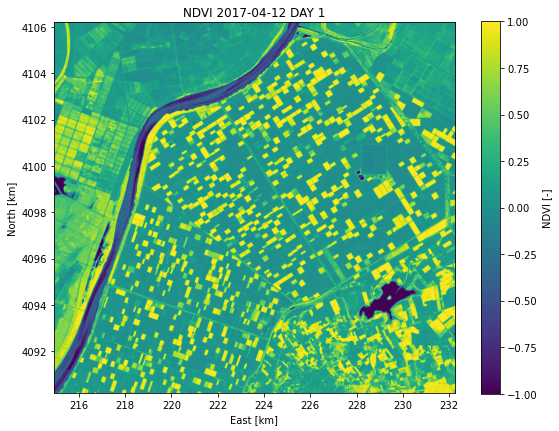

In [20]:
%matplotlib inline

band = 0

plt.figure(figsize=(8, 8))
fig = plt.imshow(NDVI[band, :, :], extent=extent, cmap=cmap, clim=clim)
plt.title('NDVI 2017-04-12')
plt.title('NDVI ' + tsdatestrings[band] + ' DAY ' + str(int(ts[band])))
plt.ylabel('North [km]')
plt.xlabel('East [km]')
plt.colorbar(label='NDVI [-]', fraction=0.0417, pad=0.06)
plt.show()


## Create a video with the unfiltered NDVI data

A video is created showing the (unfiltered) NDVI data. We use `imshow` to  display matrix NDVI(i,:,:) as an image for day *i*, using the colormap of your choice (see previous section).

The figure statetement is called only once, imshow is called from within the loop over days, and the output is appended to the list of frames.

There are several ways to display the animation from a notebook,

- show the animation in a separate window using qt (`%matplotlib qt`)
- show the animation in a qt window inside the notebook  (`%matplotlib notebook`)
- show the animation inline usign html5 (`%matplotlib inline` with html5 lines uncommented)

If you are using JupyterLab then inline with html5 will work.

You can also save the animation as either a mpeg file or an animated gif (both are commented out at the moment).

C:\Users\maxli\anaconda3\envs\BPD4a\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


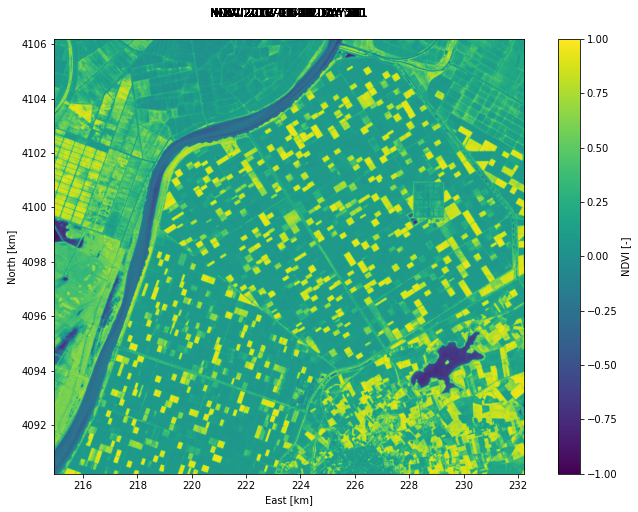

In [31]:
# %matplotlib qt        # for using Qt
# %matplotlib notebook  # for Qt inline in notebook
# from IPython.display import HTML     # uncomment for inline html5
# %matplotlib inline    # for inline html5
# %matplotlib notebook

fig, ax = plt.subplots(figsize=(10, 8))

# frames is a list of lists, each row is a list of artists to draw in the current frame;
# here we are just animating one artist, the image, in each frame
frames = []
ndates = NDVI.shape[0]
for i in range(ndates):
    title = 'test'
    titlestr = 'NDVI ' + tsdatestrings[i] + ' DAY ' + str(int(ts[i]))
    im = ax.imshow(NDVI[i, :, :], extent=extent, aspect='equal',
                   cmap=cmap, clim=clim, animated=True)  # im = Add your images here
    title = ax.text(0.5, 1.05, titlestr,
                    size=plt.rcParams["axes.titlesize"], ha="center", transform=ax.transAxes, animated=True)
    frames.append([im, title])

plt.ylabel('North [km]')
plt.xlabel('East [km]')
fig.colorbar(im, ax=ax, label='NDVI [-]', fraction=0.0417, pad=0.06)

ani = animation.ArtistAnimation(
    fig, frames, interval=300, blit=False, repeat_delay=500)



# ani.save('NDDVI_unfiltered.mp4')
# ani.save('NDDVI_unfiltered.gif')


Explain what you are seeing.

## Subplots

Instead of an animation it is sometimes better to show the images from several dates together in subplots

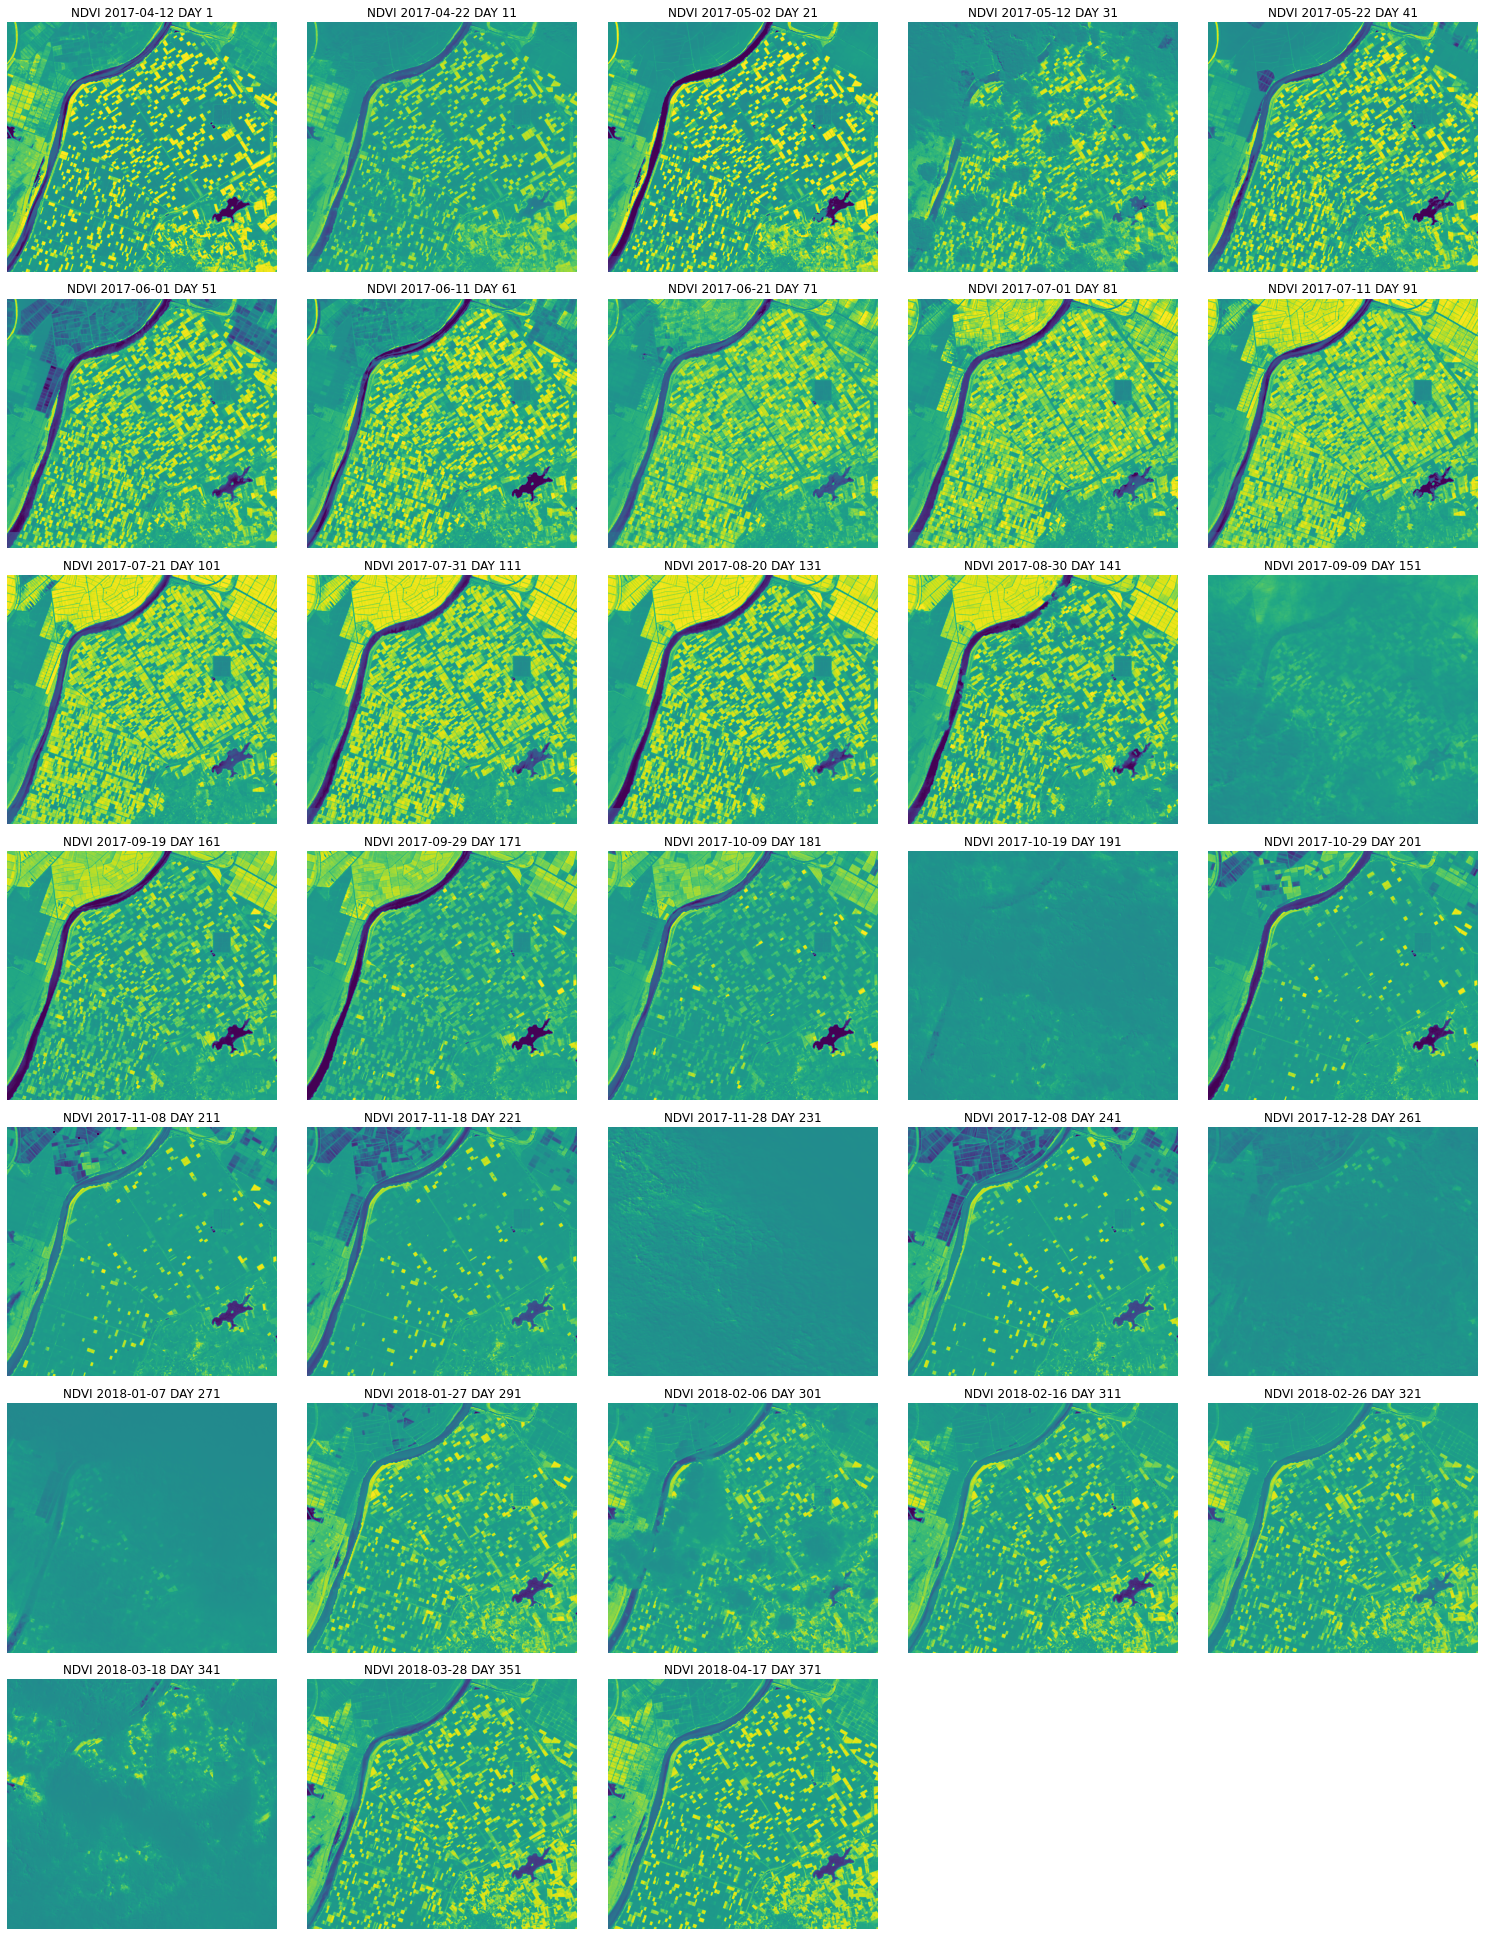

In [22]:
%matplotlib inline
ndates = NDVI.shape[0]

ncols = 5
nrows = int(np.ceil(ndates/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(21, 27), tight_layout=True)
axs = axs.flat
[axi.set_axis_off() for axi in axs]

for i in range(ndates):
    titlestr = 'NDVI ' + tsdatestrings[i] + ' DAY ' + str(int(ts[i]))
    axs[i].imshow(NDVI[i, :, :], extent=extent,
                  aspect='equal', cmap=cmap, clim=clim)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(titlestr)

plt.show()


Using `show_hist` that comes with rasterio we can plot the histograms

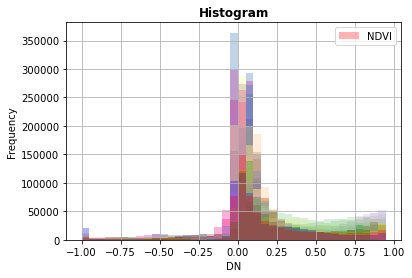

In [23]:
from rasterio.plot import show_hist
%matplotlib inline


bins = np.arange(-1, 1, .05)
plt.show()
show_hist(src, bins=bins, lw=0.0, stacked=False, alpha=0.3,
          histtype='stepfilled', title="Histogram", label="NDVI")
plt.show()


Or as subplots for the individual days

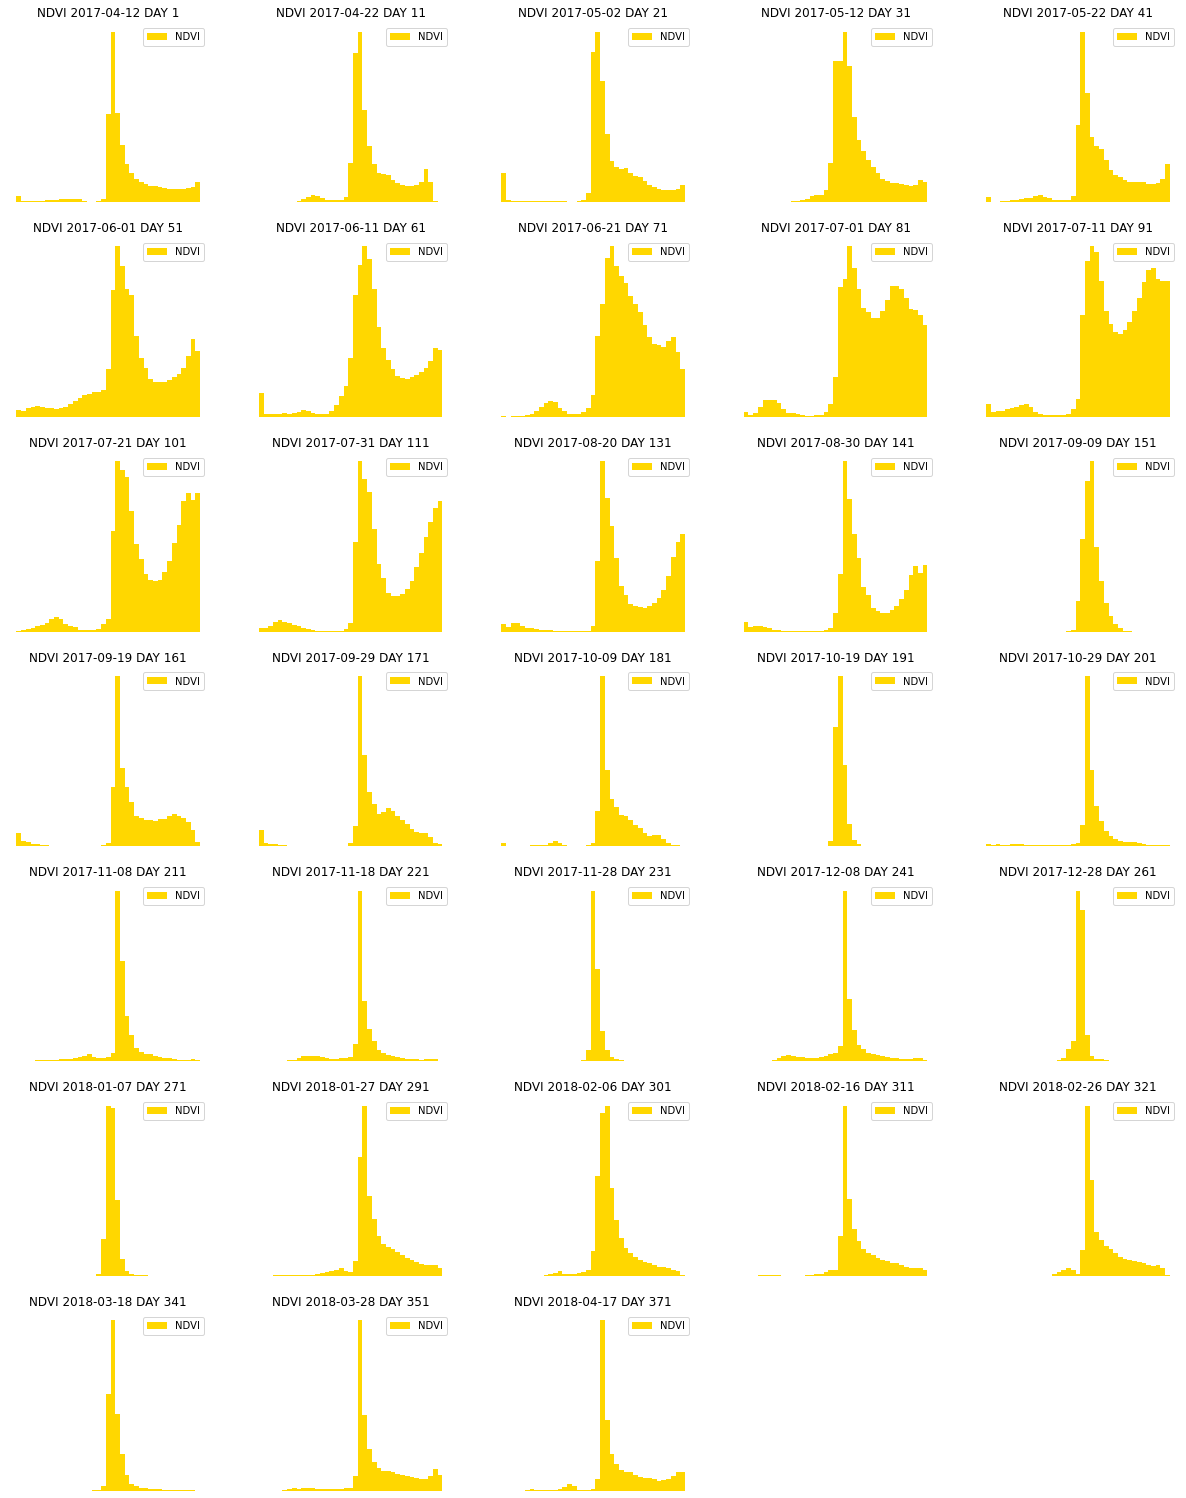

In [24]:
ndates = NDVI.shape[0]

ncols = 5
nrows = int(np.ceil(ndates/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(21, 27))
axs = axs.flat
[axi.set_axis_off() for axi in axs]

bins = np.arange(-1, 1, .05)
index = src.indexes

for i in range(ndates):
    titlestr = 'NDVI ' + tsdatestrings[i] + ' DAY ' + str(int(ts[i]))
    id = index[i]
    show_hist(src.read(id), ax=axs[i], bins=bins, lw=0.0, stacked=False, alpha=1, histtype='stepfilled',
              title="Histogram", label="NDVI")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(titlestr)


## Close a rasterio dataset

As rasterio dataset are Python dataset object the can be closed. To close a dataset, call its close() method.
```
   src.close()
```
After it’s closed, data can no longer be read. However, data that is stored in N-D arrays will be still available.

In [25]:
print('Closed?', src.closed)
print(src)
print(NDVI.shape)

src.close()
print('Closed?', src.closed)
print(src)
print(NDVI.shape)


Closed? False
<open DatasetReader name='../assignment3/cie4604_a3_hants/Hants/NDVI_BXII_time_series_2017_2018_S2A_SP.tif' mode='r'>
(33, 800, 866)
Closed? True
<closed DatasetReader name='../assignment3/cie4604_a3_hants/Hants/NDVI_BXII_time_series_2017_2018_S2A_SP.tif' mode='r'>
(33, 800, 866)


[End of this notebook]